In [1]:
# Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import config

# Setup paths
print("Loading configuration...")
print(f"Dataset directory: {config.DATASET_DIR}")
print(f"Model results: {config.MODEL_RESULT_PATH}")

Loading configuration...
Dataset directory: c:\Users\swapn\code\AI Healthcare Imaging\datasets
Model results: c:\Users\swapn\code\AI Healthcare Imaging\results


## 1. Download and Check Dataset

Uses kagglehub to download the dataset locally.

In [2]:
# Download dataset using Kaggle API
import shutil
import os

# Workaround for Kaggle API bug - set env var BEFORE importing kaggle
if "KAGGLE_API_TOKEN" not in os.environ:
    os.environ["KAGGLE_API_TOKEN"] = ""

from kaggle.api.kaggle_api_extended import KaggleApi

DATASET_DIR = Path(config.DATASET_DIR)

# Download dataset directly if not already there
if not DATASET_DIR.exists() or not (DATASET_DIR / "imagesTr").exists():
    print(f"Downloading dataset to: {DATASET_DIR}")
    
    # Initialize Kaggle API
    api = KaggleApi()
    
    # Download dataset
    DATASET_DIR.mkdir(parents=True, exist_ok=True)
    
    api.dataset_download_files(
        config.KAGGLE_DATASET,
        path=DATASET_DIR,
        unzip=True,
        quiet=False
    )
    
    # Move Task02_Heart contents up to DATASET_DIR if needed
    task_dir = DATASET_DIR / "Task02_Heart"
    if task_dir.exists():
        for item in task_dir.iterdir():
            shutil.move(str(item), str(DATASET_DIR / item.name))
        task_dir.rmdir()
    
    print("✓ Dataset downloaded to datasets/ directory")
else:
    print("✓ Using existing dataset in project directory")

# Use local dataset directory
images_path = DATASET_DIR / "imagesTr"
labels_path = DATASET_DIR / "labelsTr"

if images_path.exists() and labels_path.exists():
    print("✓ Dataset structure verified")
    print(f"  Images: {images_path}")
    print(f"  Labels: {labels_path}")
else:
    print("⚠️ Dataset structure not as expected")

✓ Using existing dataset in project directory
✓ Dataset structure verified
  Images: c:\Users\swapn\code\AI Healthcare Imaging\datasets\imagesTr
  Labels: c:\Users\swapn\code\AI Healthcare Imaging\datasets\labelsTr


## 2. Explore Dataset Files

In [ ]:
import glob

# Get all files
all_images = sorted(glob.glob(str(images_path / "**/*.nii")))
all_labels = sorted(glob.glob(str(labels_path / "**/*.nii")))

print(f"Total images: {len(all_images)}")
print(f"Total labels: {len(all_labels)}")
print("\nSample files:")
for i in range(min(3, len(all_images))):
    print(f"  {Path(all_images[i]).name}")

Total images: 20
Total labels: 20

Sample files:
  la_003.nii
  la_004.nii
  la_005.nii


## 3. Load and Visualize Sample Image

In [7]:
import nibabel as nib

# Load first image and label
sample_image = nib.load(all_images[0])
sample_label = nib.load(all_labels[0])

image_data = sample_image.get_fdata()
label_data = sample_label.get_fdata()

print(f"Image shape: {image_data.shape}")
print(f"Label shape: {label_data.shape}")
print(f"Image intensity range: [{image_data.min():.2f}, {image_data.max():.2f}]")
print(f"Unique label values: {np.unique(label_data)}")

Image shape: (320, 320, 130)
Label shape: (320, 320, 130)
Image intensity range: [0.00, 1999.00]
Unique label values: [0. 1.]
Unique label values: [0. 1.]


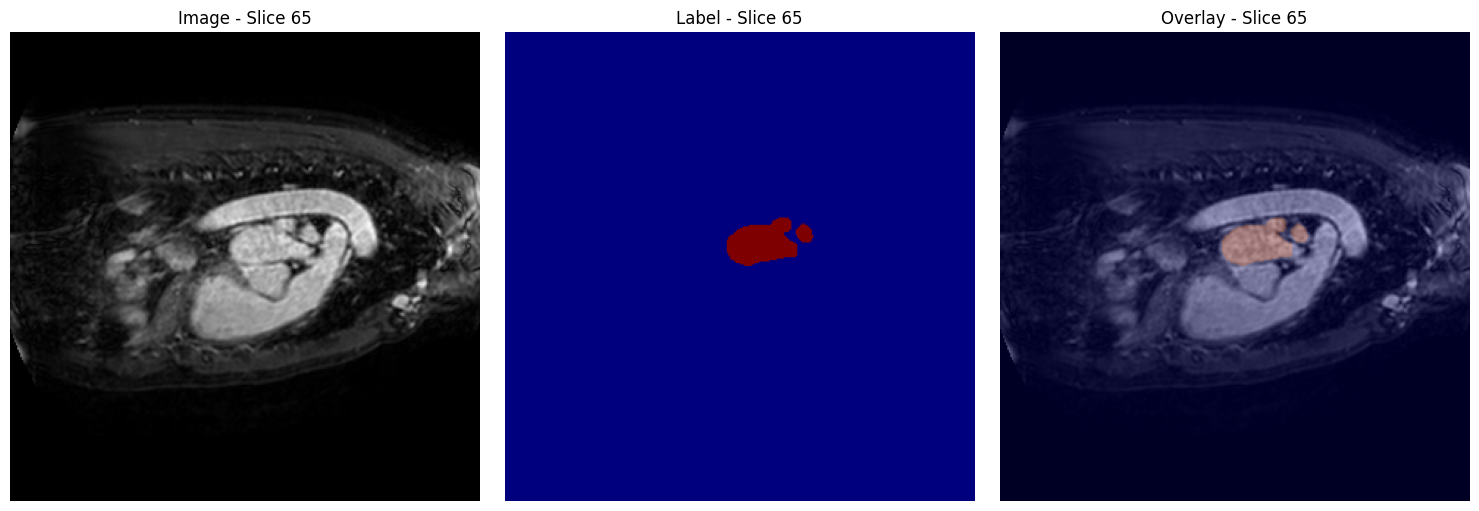

In [8]:
# Visualize middle slices
slice_idx = image_data.shape[2] // 2

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image_data[:, :, slice_idx], cmap='gray')
axes[0].set_title(f'Image - Slice {slice_idx}')
axes[0].axis('off')

axes[1].imshow(label_data[:, :, slice_idx], cmap='jet')
axes[1].set_title(f'Label - Slice {slice_idx}')
axes[1].axis('off')

# Overlay
axes[2].imshow(image_data[:, :, slice_idx], cmap='gray')
axes[2].imshow(label_data[:, :, slice_idx], cmap='jet', alpha=0.3)
axes[2].set_title(f'Overlay - Slice {slice_idx}')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 4. Prepare Data Loaders

Load data using MONAI transforms (same as training).

In [ ]:
from monai.transforms import (
    Compose, LoadImaged, AddChanneld, ScaleIntensityRanged,
    Orientationd, Spacingd, ToTensord
)
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism

set_determinism(seed=config.SEED)

# Create data dicts
data_dicts = [
    {"image": image, "label": label}
    for image, label in zip(all_images[:5], all_labels[:5])  # First 5 for quick exploration
]

# Define transforms
transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    AddChanneld(keys=["image", "label"]),
    Spacingd(keys=["image", "label"], pixdim=config.PIXDIM, mode=("bilinear", "nearest")),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    ScaleIntensityRanged(keys=["image"], a_min=config.A_MIN, a_max=config.A_MAX, b_min=0.0, b_max=1.0, clip=True),
    ToTensord(keys=["image", "label"]),
])

# Create dataset
dataset = Dataset(data=data_dicts, transform=transforms)
dataloader = DataLoader(dataset, batch_size=1)

print(f"✓ Created dataset with {len(dataset)} samples")

In [ ]:
# Visualize transformed data
from monai.utils import first

sample = first(dataloader)
image_tensor = sample["image"][0, 0]  # Remove batch and channel dims
label_tensor = sample["label"][0, 0]

print(f"Transformed image shape: {image_tensor.shape}")
print(f"Transformed label shape: {label_tensor.shape}")

# Visualize middle slice
slice_idx = image_tensor.shape[2] // 2

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(image_tensor[:, :, slice_idx].cpu().numpy(), cmap='gray')
axes[0].set_title('Transformed Image')
axes[0].axis('off')

axes[1].imshow(label_tensor[:, :, slice_idx].cpu().numpy(), cmap='jet')
axes[1].set_title('Transformed Label')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 5. Load Trained Model

Load the best trained model for inference.

In [ ]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create model
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

# Load trained weights
model_path = Path(config.MODEL_RESULT_PATH) / "best_metric_model.pth"
if model_path.exists():
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(f"✓ Model loaded from {model_path}")
else:
    print(f"⚠️ Model not found at {model_path}")
    print("Train the model first using: python train.py")

## 6. Run Inference and Visualize Results

In [ ]:
# Run inference on a sample
model.eval()
with torch.no_grad():
    sample = first(dataloader)
    image = sample["image"].to(device)
    label = sample["label"].to(device)
    
    # Forward pass
    output = model(image)
    
    # Get prediction (argmax)
    prediction = torch.argmax(output, dim=1, keepdim=True)
    
    print(f"Input shape: {image.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Prediction shape: {prediction.shape}")

In [ ]:
# Visualize prediction
image_np = image[0, 0].cpu().numpy()
label_np = (label[0, 0] != 0).cpu().numpy()  # Binary label
pred_np = prediction[0, 0].cpu().numpy()

# Middle slice
slice_idx = image_np.shape[2] // 2

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(image_np[:, :, slice_idx], cmap='gray')
axes[0].set_title('Input Image')
axes[0].axis('off')

axes[1].imshow(label_np[:, :, slice_idx], cmap='jet')
axes[1].set_title('Ground Truth')
axes[1].axis('off')

axes[2].imshow(pred_np[:, :, slice_idx], cmap='jet')
axes[2].set_title('Prediction')
axes[2].axis('off')

# Overlay
axes[3].imshow(image_np[:, :, slice_idx], cmap='gray')
axes[3].imshow(pred_np[:, :, slice_idx], cmap='jet', alpha=0.3)
axes[3].set_title('Prediction Overlay')
axes[3].axis('off')

plt.tight_layout()
plt.show()

## 7. View Training Metrics

Load and visualize training history.

In [ ]:
result_path = Path(config.MODEL_RESULT_PATH)

# Check if training results exist
loss_train_path = result_path / 'loss_train.npy'
loss_test_path = result_path / 'loss_test.npy'
metric_train_path = result_path / 'metric_train.npy'
metric_test_path = result_path / 'metric_test.npy'

if all(p.exists() for p in [loss_train_path, loss_test_path, metric_train_path, metric_test_path]):
    train_loss = np.load(loss_train_path)
    test_loss = np.load(loss_test_path)
    train_metric = np.load(metric_train_path)
    test_metric = np.load(metric_test_path)
    
    print("✓ Training metrics loaded")
    print(f"  Epochs trained: {len(train_loss)}")
    print(f"  Best validation Dice: {max(test_metric):.4f}")
else:
    print("⚠️ Training metrics not found. Train the model first.")

In [ ]:
# Plot training history
if all(p.exists() for p in [loss_train_path, loss_test_path, metric_train_path, metric_test_path]):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    axes[0, 0].plot(train_loss)
    axes[0, 0].set_title("Training Loss")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Loss")
    axes[0, 0].grid(True)
    
    axes[0, 1].plot(test_loss)
    axes[0, 1].set_title("Validation Loss")
    axes[0, 1].set_xlabel("Epoch")
    axes[0, 1].set_ylabel("Loss")
    axes[0, 1].grid(True)
    
    axes[1, 0].plot(train_metric)
    axes[1, 0].set_title("Training Dice Metric")
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylabel("Dice")
    axes[1, 0].grid(True)
    
    axes[1, 1].plot(test_metric)
    axes[1, 1].set_title("Validation Dice Metric")
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylabel("Dice")
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

## Summary

This notebook provides:
- ✅ Dataset download and exploration
- ✅ Data visualization
- ✅ MONAI data loading pipeline
- ✅ Model inference testing
- ✅ Training metrics visualization

**Next Steps:**
1. Run full training: `python train.py`
2. Push to Kaggle: `kaggle kernels push`
3. Monitor training on Kaggle with free GPU